## Gig Economy Project

By: Janet Taylor & Evan Kessler

Workers in the gig economy (i.e., Uber, GrubHub, TaskRabbit, etc.) depend on the reviews they get to continue working on the platform. Workers on those platforms are often affected by receiving negative reviews that describe elements that were not under their control. The project explores how the analysis of online reviews can detect when unfair reviews are left to workers and identify the type of unfair review that was left.

In [211]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import checkpoint2
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from textblob.classifiers import NaiveBayesClassifier


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [212]:
uber = pd.read_csv("uber_cleaned.csv")
lyft = pd.read_csv("lyft_cleaned.csv")
pd.options.display.max_colwidth = 500

In [213]:
uber["Review Body"] = checkpoint2.preprocess_reviews(uber)

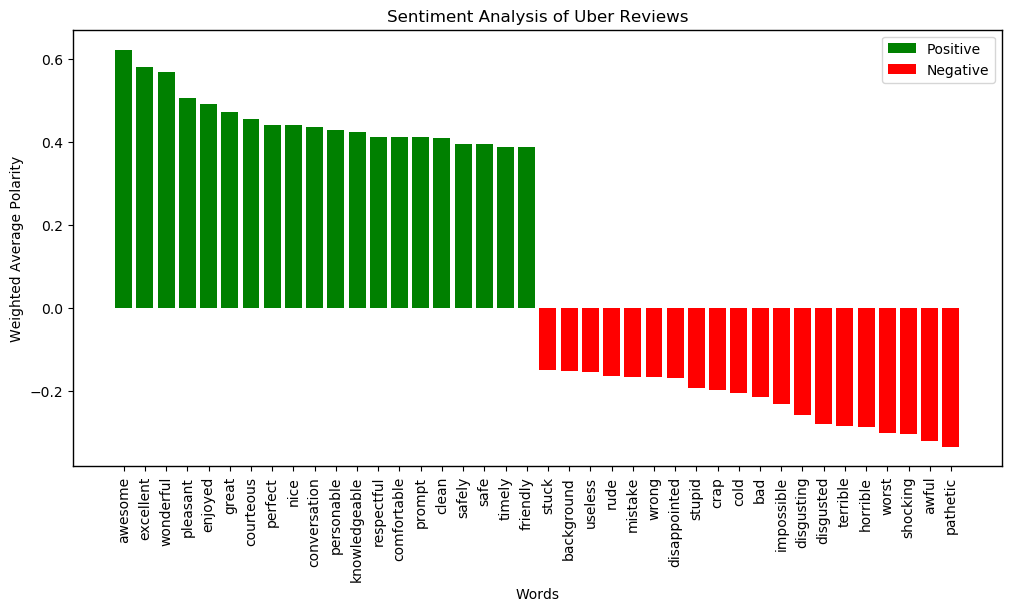

In [214]:
sentiment = checkpoint2.get_weighed_sentiment_counts(checkpoint2.get_sentiment_and_counts(uber))
uber['Sentiment'] = [sum([sentiment[word] if word in sentiment else 0 for word in str(review).split()]) for review in uber['Review Body']]

checkpoint2.plot_sentiment(dict(list(sentiment.items())[:20]), dict(list(sentiment.items())[-20:]))

In [215]:
labeled = uber[uber.Unfair.notnull()].astype({'Invited': 'int32', "Unfair": 'int32'})
X_labeled = labeled.iloc[:, labeled.columns != 'Unfair']
y_labeled = labeled["Unfair"]
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.33, random_state=938)

In [216]:
cl_train = []
for x, y in zip(X_train["Review Body"], y_train):
    cl_train.append((x, y))

cl = NaiveBayesClassifier(cl_train, format='json')

predictions = [cl.classify(item) for item in X_test["Review Body"]]
checkpoint2.print_metrics(y_test, predictions)

labeled['BayesResult'] = [cl.classify(x) for x in labeled["Review Body"]]
X_labeled = labeled.iloc[:, labeled.columns.isin(["# Reviews By User", "Invited", "Rating", "Sentiment", "BayesResult"])]
y_labeled = labeled["Unfair"]
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.33, random_state=938)

Accuracy: 0.8181818181818182
Recall: 0.5217391304347826
Precision: 0.3870967741935484
F1: 0.4444444444444444


SVC kernel is poly


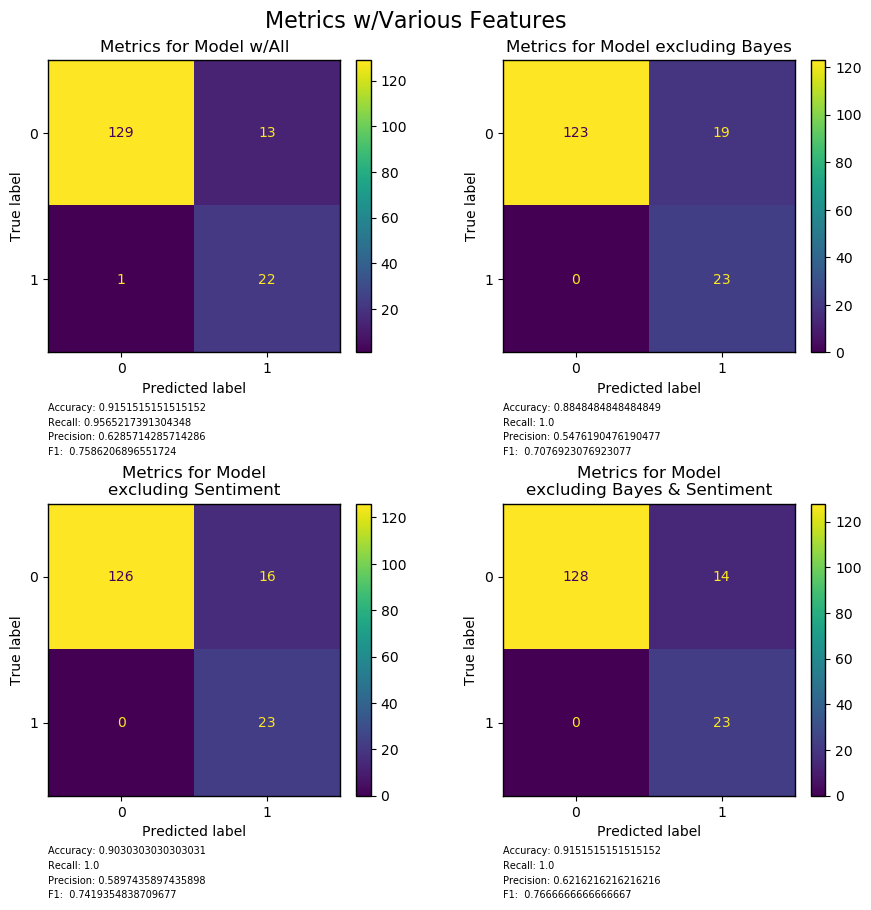

In [223]:

plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1

kernel = 'poly'
svc = SVC(kernel=kernel, degree=7, class_weight='balanced', coef0=2.4, shrinking=False)
print("SVC kernel is " + kernel)

all_include = checkpoint2.perform_SVC(svc, [], X_train, y_train, X_test, y_test)
bayes_exclude = checkpoint2.perform_SVC(svc, ["BayesResult"], X_train, y_train, X_test, y_test)
sent_exclude = checkpoint2.perform_SVC(svc, ["Sentiment"], X_train, y_train, X_test, y_test)
bayes_sent_exclude = checkpoint2.perform_SVC(svc, ["Sentiment", "BayesResult"], X_train, y_train, X_test, y_test)

figure, axis = plt.subplots(2, 2, figsize=(9, 9))
figure.suptitle("Metrics w/Various Features", fontsize=16, ha='center')
checkpoint2.plot_metrics(all_include, "Metrics for Model w/All", ax=axis[0, 0])
checkpoint2.plot_metrics(bayes_exclude, "Metrics for Model excluding Bayes", ax=axis[0, 1])
checkpoint2.plot_metrics(sent_exclude, "Metrics for Model\nexcluding Sentiment", ax=axis[1, 0])
checkpoint2.plot_metrics(bayes_sent_exclude, "Metrics for Model\nexcluding Bayes & Sentiment", ax=axis[1, 1])